In [1]:
import numpy as np
import os, sys


simulations_path = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), 'python/'))
print(simulations_path)
sys.path.insert(1, simulations_path)
from rate_estimators import LpfExactRegister, LpfMinSketch

def strip_extension(filename: str) -> str:
    return ".".join(filename.split(".")[:-1])


def get_trace_filenames():
    # files are of the form (timestamp, hashed_5tuple, pkt_len)
    data_dir = os.path.abspath("../hashed_anonflows/")

    trace_filenames = []
    for file in os.listdir(data_dir):
        filepath = os.path.join(data_dir, file)
        if os.path.isfile(filepath):
            trace_filenames.append(filepath)
    return trace_filenames
            
            
filenames = get_trace_filenames()

def get_unique_5tuples():
    pass
    
            

            
def compute_bandwidth_accuracy_points():
    """
    Load a trace file, take a subset of users
    """
    pass


/Users/macdavid/Code/approx-upf/python


In [ ]:
# plot 

In [15]:
rows = np.load(filenames[0])
rows = rows[rows[:, 0].argsort()]

In [16]:
(max(rows[:,0]) - min(rows[:,0])) / 1e9

0.111776555

In [ ]:
num_epochs = len(np.distinct(epoch_id)

In [17]:
ts_usec =  rows[:,0] - rows[0,0]
epoch = 1048.576
epoch_id = ts_usec // epoch

TSTAMP, FLOWID, PKTSIZE = 0,1,2

scale = 0
decay = 4000

lms = LpfMinSketch(width=3, height=2048, scale=scale, time_constant=decay)
lpf = LpfExactRegister(scale=scale, time_constant=decay)

estimated_rates = np.zeros_like(ts_usec)
true_rates = np.zeros_like(ts_usec)
for i, (timestamp, flowid, pkt_len) in enumerate(rows):
    estimated_rates[i] = lms.update((flowid,), timestamp, pkt_len)
    true_rates[i] = lpf.update((flowid,), timestamp, pkt_len)

<Figure size 432x288 with 0 Axes>

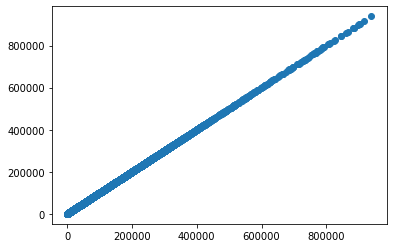

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt

plt.scatter(true_rates[::100], estimated_rates[::100])
plt.savefig("tmp.png")

plt.figure()

In [ ]:
# four lines: three with different sizes of CMS, and one with collision-free LPF
# demand curves?
# how to compare a LPF and a sliding window rate? use same time constant?
# find time constant that gives roughly the same values as an LPF

In [50]:
def get_rates_using_estimator(estimator):
    result = np.zeros_like(rows[:,0])
    for i, (timestamp, flowid, pkt_len) in enumerate(rows[:100]):
        result[i] = estimator.update((flowid,), timestamp, pkt_len)
    return result

In [60]:
func = lambda (estimator,rows):[estimator.update((flowid,), timestamp, pkt_len) for (timestamp, flowid, pkt_len) in rows[:100]]

SyntaxError: invalid syntax (1919456006.py, line 1)

In [63]:
def get_rates_using_estimator(estimator):
    result = np.zeros_like(rows[:,0])
    for i, (timestamp, flowid, pkt_len) in enumerate(rows):
        result[i] = estimator.update((flowid,), timestamp, pkt_len)
    return result

lmses = [LpfMinSketch(width=3, height=h, scale=scale, time_constant=decay) 
         for h in [512, 1024, 2048]]

exact_lpf = LpfExactRegister(scale=scale, time_constant=decay)

all_estimators = lmses + [exact_lpf]


all_estimators_rates = []
for estimator in all_estimators:
    result = get_rates_using_estimator(estimator)
    all_estimators_rates.append(result)
    



In [64]:
#np.save("all_estimators_rates.npy", all_estimators_rates)

In [69]:
max(epoch_id)

106598.0

In [75]:
import numba 
@numba.njit(parallel=True)
def get_epoch_demands(epoch_id,pkt_len):
    demands=np.zeros(int(max(epoch_id)+1), dtype=np.float64)
    for i in numba.prange(len(rows)):
        eid=int(epoch_id[i])
        plen=pkt_len[i]
        demands[eid]+=plen
    return demands

%time per_epoch_demand=get_epoch_demands(epoch_id,rows[:,2])


CPU times: user 773 ms, sys: 12.5 ms, total: 785 ms
Wall time: 755 ms


In [77]:
#set their avg

capacity_per_epoch=np.mean(per_epoch_demand)
capacity_per_epoch

74994.1753393559

0               0.0
1               0.0
2               0.0
3               0.0
4               0.0
             ...   
9763274    106598.0
9763275    106598.0
9763276    106598.0
9763277    106598.0
9763278    106598.0
Length: 9763279, dtype: float64

340262

In [115]:
import pandas as pd
df=pd.DataFrame({
    "epochID":pd.Series(epoch_id).astype(int),
    "flowID":rows[:,1],# % 100000007,
    "pktLen":rows[:,2].astype(int)
})
df

,epochID,flowID,pktLen
0,0,10807371370883154833,1326
1,0,10807371370883154833,1326
2,0,15166406817608355950,52
3,0,15166406817608355950,52
4,0,15166406817608355950,52
...,...,...,...
9763274,106598,8281528476671899928,52
9763275,106598,253563452014364431,1426
9763276,106598,253563452014364431,1426
9763277,106598,8281528476671899928,52


In [116]:
total_demand_per_epoch=df.groupby("epochID").sum()['pktLen'].to_numpy()

In [160]:
per_flow_demand_per_epoch=df.groupby(["epochID","flowID"]).sum()

In [178]:
per_flow_demand_per_epoch #.iloc[:100] #.reset_index()#.set_index(["epochID","flowID"])

pktLen
epochID flowID                      
0       872312209886459985        60
        1500098232493061493       40
        2008281119861432815       52
        2797617837009500321      104
        3389127386831065153      202
...                              ...
106598  15435615168515710807      80
        15468700541530294356    7500
        15554710749448465491      60
        15929561359506126722    1034
        17991450777783508971     293

[3111693 rows x 1 columns]

In [188]:
import tqdm


@numba.jit(parallel=True)
def get_ppd():
    per_packet_demand_per_epoch=np.zeros_like(epoch_id)

    for i in numba.prange((len(rows))):
        per_packet_demand_per_epoch[i]=per_flow_demand_per_epoch.loc[ epoch_id[i], rows[i,1] ]
    return per_packet_demand_per_epoch

%time per_packet_demand_per_epoch=get_ppd()
per_packet_demand_per_epoch

/var/folders/m7/y2dr7_3n31g86fxzbjmp_s740000gn/T/ipykernel_94653/2328478175.py:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_ppd" failed type inference due to: Untyped global name 'per_flow_demand_per_epoch': Cannot determine Numba type of <class 'pandas.core.frame.DataFrame'>

File "../../../../../var/folders/m7/y2dr7_3n31g86fxzbjmp_s740000gn/T/ipykernel_94653/2328478175.py", line 9:
<source missing, REPL/exec in use?>

  @numba.jit(parallel=True)
/var/folders/m7/y2dr7_3n31g86fxzbjmp_s740000gn/T/ipykernel_94653/2328478175.py:4: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "get_ppd" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "../../../../../var/folders/m7/y2dr7_3n31g86fxzbjmp_s740000gn/T/ipykernel_94653/2328478175.py", line 8:
<source missing, REPL/exec in use?>

  @numba.jit(parallel=True)
/usr/local/

CPU times: user 20min 59s, sys: 3.95 s, total: 21min 3s
Wall time: 21min 7s


array([ 5304.,  5304.,   572., ..., 15686.,   260.,   293.])

In [190]:
np.save("per_packet_demand_per_epoch.npy",per_packet_demand_per_epoch)

In [177]:
#per_flow_demand_per_epoch.reset_index().set_index(["epochID","flowID"])[0,1500098232493061493]

In [203]:
fths # fair rate per per flow at every epoch
per_packet_demand_per_epoch

true_drop_rate=1-np.min([np.ones(len(rows)), per_packet_demand_per_epoch / fths[np.int32(epoch_id)]],  axis=0)
true_drop_rate.shape

(9763279,)

In [257]:
[np.mean(est_rate) for est_rate in 
    all_estimators_rates], np.mean(per_packet_demand_per_epoch)

lpf_div_factor=np.mean(all_estimators_rates[-1])/ np.mean(per_packet_demand_per_epoch)

lpf_divided_rate=[
     est_rate / lpf_div_factor 
     for est_rate in 
     all_estimators_rates
 ]
np.mean(lpf_divided_rate[-1])



23265.397730516575

In [264]:
all_lpf_drop_rate = [
    1-np.min([np.ones(len(rows)), x / fths[np.int32(epoch_id)]],  axis=0)
    for x in 
    lpf_divided_rate
]
all_lpf_drop_rate

[array([0.97456476, 0.94914869, 0.99900254, ..., 0.        , 0.99381673,
        0.99608889]),
 array([0.97456476, 0.94914869, 0.99900254, ..., 0.        , 0.99381673,
        0.99612614]),
 array([0.97456476, 0.94914869, 0.99900254, ..., 0.        , 0.99381673,
        0.99612614]),
 array([0.97456476, 0.94914869, 0.99900254, ..., 0.        , 0.99381673,
        0.99612614])]

In [275]:
true_drop_rate

array([0.83739127, 0.83739127, 0.98246376, ..., 0.68872151, 0.99484047,
       0.99418561])

/var/folders/m7/y2dr7_3n31g86fxzbjmp_s740000gn/T/ipykernel_94653/707626084.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('lpf_cms.png')


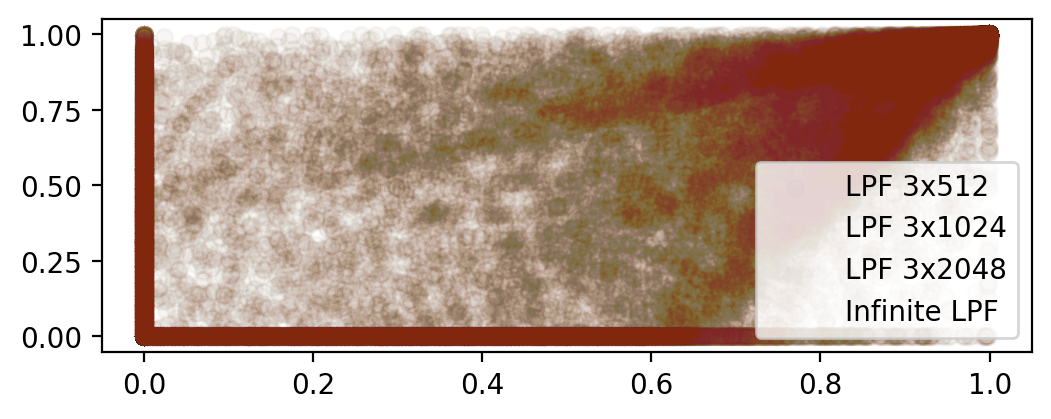

In [260]:
labels=[
    "LPF 3x%d"%i for i in
    [512, 1024, 2048]
]+[
    "Infinite LPF"
]
for i in range(4):
    plt.scatter(true_drop_rate[::100], all_lpf_drop_rate[i][::100], label=labels[i],alpha=0.01)
plt.legend()
plt.savefig('lpf_cms.png')

In [261]:
labels=[
    "LPF 3x%d"%i for i in
    [512, 1024, 2048]
]
for i in range(3):
    plt.scatter(all_lpf_drop_rate[-1], all_lpf_drop_rate[i], label=labels[i],alpha=1)
plt.legend()

plt.savefig('lpf_as_groundtruth.png')

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x12bdcf280> (for post_execute):


KeyboardInterrupt: 

count    9.763279e+06
mean     6.026351e-01
std      4.336636e-01
min      0.000000e+00
25%      0.000000e+00
50%      8.629899e-01
75%      9.944484e-01
max      9.997641e-01
dtype: float64

In [285]:
import collections

In [291]:

def dedup_scatter_bignum(v_x,v_y):
    scale_x=0.001*max(v_x)
    scale_y=0.001*max(v_y)
    
    
    bin_x= ((v_x/scale_x) //1)*1000
    bin_y= ((v_y/scale_y) //1)*1000
    return collections.Counter(
        tqdm.tqdm(zip(bin_x,bin_y))
    )

In [294]:



rate_x=fths[np.int32(epoch_id)]
demand_y_gt=per_packet_demand_per_epoch
demand_y_lpfs=lpf_divided_rate

demand_y=demand_y_lpfs+[demand_y_gt]



0it [00:00, ?it/s]
179701it [00:00, 1796951.73it/s]
375849it [00:00, 1893687.69it/s]
575552it [00:00, 1940778.67it/s]
773024it [00:00, 1954147.23it/s]
968439it [00:00, 1931471.04it/s]
1165067it [00:00, 1943187.31it/s]
1359425it [00:00, 1886859.92it/s]
1548430it [00:00, 1885905.08it/s]
1737236it [00:00, 1880303.66it/s]
1925409it [00:01, 1869114.16it/s]
2112419it [00:01, 1837154.50it/s]
2309409it [00:01, 1876622.14it/s]
2497262it [00:01, 1852076.41it/s]
2682641it [00:01, 1845646.02it/s]
2867318it [00:01, 1800725.67it/s]
3047644it [00:01, 1780760.29it/s]
3225894it [00:01, 1769065.26it/s]
3402908it [00:01, 1719355.93it/s]
3581515it [00:01, 1738632.74it/s]
3771967it [00:02, 1787108.21it/s]
3950995it [00:02, 1776944.12it/s]
4128908it [00:02, 1726882.50it/s]
4306797it [00:02, 1741965.98it/s]
4481317it [00:02, 1713950.50it/s]
4652983it [00:02, 1711864.65it/s]
4824354it [00:02, 1679521.15it/s]
4994888it [00:02, 1687031.22it/s]
5185005it [00:02, 1749986.66it/s]
5376257it [00:02, 1798052.48it/s]

3236707it [00:01, 2115031.18it/s]
3452196it [00:01, 2126850.38it/s]
3665202it [00:01, 2127781.83it/s]
3879666it [00:01, 2132790.70it/s]
4097985it [00:01, 2147837.48it/s]
4317848it [00:02, 2163014.81it/s]
4534182it [00:02, 2154638.00it/s]
4749674it [00:02, 2139727.61it/s]
4972803it [00:02, 2166968.57it/s]
5193490it [00:02, 2178855.68it/s]
5411416it [00:02, 2143818.49it/s]
5625941it [00:02, 2124752.62it/s]
5838530it [00:02, 2113653.92it/s]
6050073it [00:02, 2114165.88it/s]
6266216it [00:02, 2128176.93it/s]
6483468it [00:03, 2141359.80it/s]
6697651it [00:03, 2139567.40it/s]
6916688it [00:03, 2154709.35it/s]
7132188it [00:03, 2151565.76it/s]
7361220it [00:03, 2193034.01it/s]
7580551it [00:03, 2186370.40it/s]
7802292it [00:03, 2195621.70it/s]
8021874it [00:03, 2189477.62it/s]
8250159it [00:03, 2217361.19it/s]
8471917it [00:03, 2215976.16it/s]
8693530it [00:04, 2200034.78it/s]
8913567it [00:04, 2174372.19it/s]
9131080it [00:04, 2151802.50it/s]
9346340it [00:04, 2128975.11it/s]
9763279it [00:

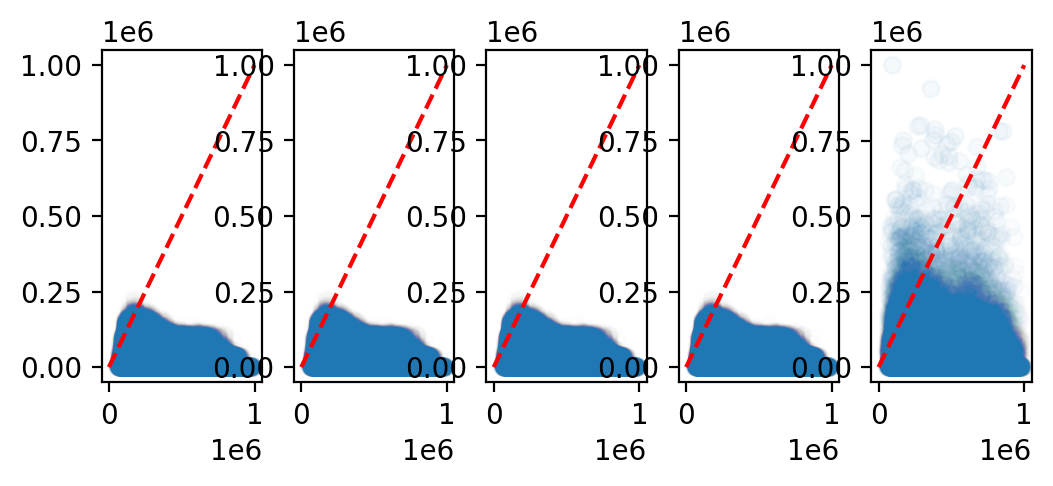

In [293]:

scatter_true=[
    dedup_scatter_bignum(rate_x,demand_y[i]) for i in (range(5))
]
fig, axes = plt.subplots(1,5)
for i in tqdm.tqdm(range(5)):
    axes[i].scatter(
      [xy[0] for xy,v in scatter_true[i].items()],
      [xy[1] for xy,v in scatter_true[i].items()],
        marker="o",
        alpha=[min(1,0.0001*v) for k,v in scatter_true[i].items()],
    )
    maxx=max([xy[1] for xy,v in scatter_true[i].items()])
    axes[i].plot([0,maxx],[0,maxx],'--',color='r')

In [288]:
pd.Series(rate_x).describe(), pd.Series(per_packet_demand_per_epoch).describe()

(count    9.763279e+06
 mean     3.359550e+04
 std      1.769121e+04
 min      4.215000e+03
 25%      1.730600e+04
 50%      3.181018e+04
 75%      4.860218e+04
 max      7.450518e+04
 dtype: float64,
 count    9.763279e+06
 mean     2.326540e+04
 std      4.292468e+04
 min      2.800000e+01
 25%      2.400000e+02
 50%      5.304000e+03
 75%      2.968800e+04
 max      6.276460e+05
 dtype: float64)

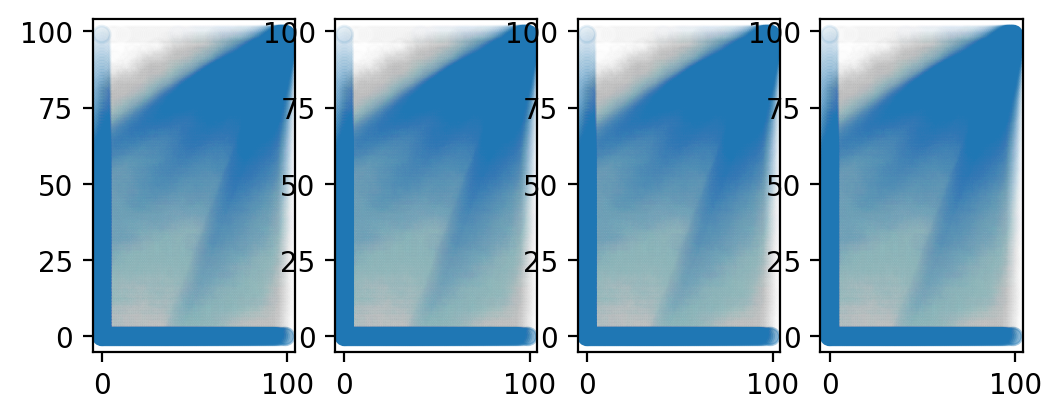

In [282]:

def dedup_scatter(v_x,v_y):
    bin_x= (v_x*10000) //100
    bin_y= (v_y*10000) //100
    return collections.Counter(
        zip(bin_x,bin_y)
    )
scatter_true=[
    dedup_scatter(all_lpf_drop_rate[i], true_drop_rate) for i in range(4)
]
fig, axes = plt.subplots(1,4)
for i in range(4):
    axes[i].scatter(
      [xy[0] for xy,v in scatter_true[i].items()],
      [xy[1] for xy,v in scatter_true[i].items()],
        marker="o",
        alpha=[min(1,0.0001*v) for k,v in scatter_true[i].items()],
    )


In [273]:


binned = [dedup_scatter(all_lpf_drop_rate[i], all_lpf_drop_rate[-1]) for i in range(3)]

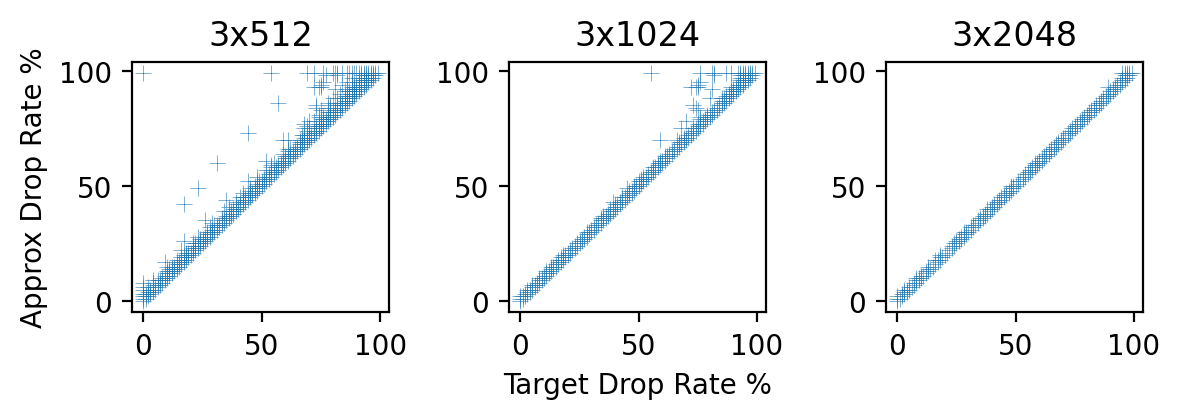

In [296]:
plt.rcParams['figure.figsize'] = [6, 2.2]
plt.rcParams['figure.dpi'] = 200
labels=[
    "3x%d"%i for i in
    [512, 1024, 2048]
]

fig, axes = plt.subplots(1,3)
for i in reversed(range(3)):

    axes[i].scatter(
      [xy[0] for xy,v in binned[i].items()],
      [xy[1] for xy,v in binned[i].items()],
        marker="+",
        lw=0.2
        #alpha=[min(1,0.1*v) for k,v in binned[i].items()],
    )
    axes[i].set_title(labels[i])
axes[0].set_ylabel("Approx Drop Rate %")
axes[1].set_xlabel("Target Drop Rate %")
plt.tight_layout()

In [262]:
0

0

In [179]:
#per_flow_demand_per_epoch.reset_index()

/var/folders/m7/y2dr7_3n31g86fxzbjmp_s740000gn/T/ipykernel_94653/2476392624.py:3: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale("log",basey=2)


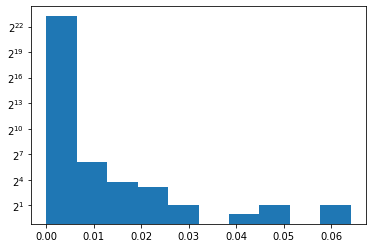

In [211]:
plt.hist(all_lpf_drop_rate[-1]-all_lpf_drop_rate[2])

plt.yscale("log",basey=2)

In [86]:
from collections import defaultdict
from estimators import correct_threshold

@numba.jit(parallel=True)
def get_fair_threshold(epoch_id,row, capacity_per_epoch):
    threshold_per_epoch=np.zeros(int(max(epoch_id)+1))
    for i in numba.prange(int(max(epoch_id)+1)):
        pkts_in_epoch=rows[ epoch_id==i ]

        flow_sizes_in_epoch=defaultdict(int)
        for _,fid,sz in pkts_in_epoch:
            flow_sizes_in_epoch[int(fid)]+=sz
        if len(pkts_in_epoch)==0:
            threshold_per_epoch[i]=float('inf')
        else:
            threshold_per_epoch[i]=correct_threshold(flow_sizes_in_epoch.values(), capacity_per_epoch)
    return threshold_per_epoch
    

%time fths=get_fair_threshold(epoch_id,rows,capacity_per_epoch)
fths

/var/folders/m7/y2dr7_3n31g86fxzbjmp_s740000gn/T/ipykernel_94653/648256995.py:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_fair_threshold" failed type inference due to: Untyped global name 'defaultdict': Cannot determine Numba type of <class 'type'>

File "../../../../../var/folders/m7/y2dr7_3n31g86fxzbjmp_s740000gn/T/ipykernel_94653/648256995.py", line 10:
<source missing, REPL/exec in use?>

  @numba.jit(parallel=True)
/var/folders/m7/y2dr7_3n31g86fxzbjmp_s740000gn/T/ipykernel_94653/648256995.py:4: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "get_fair_threshold" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "../../../../../var/folders/m7/y2dr7_3n31g86fxzbjmp_s740000gn/T/ipykernel_94653/648256995.py", line 7:
<source missing, REPL/exec in use?>

  @numba.jit(parallel=True)
/usr/local/lib/python3.9/site

CPU times: user 40min 33s, sys: 5.46 s, total: 40min 38s
Wall time: 40min 43s


array([32618.17533936, 43085.17533936, 15789.        , ...,
       17586.        , 36341.17533936, 50392.17533936])

In [87]:
#np.save("fths.npy", fths)

In [36]:
sorted(flow_sizes_in_epoch.values()), sum(flow_sizes_in_epoch.values())

([40.0,
  40.0,
  40.0,
  40.0,
  52.0,
  54.0,
  80.0,
  80.0,
  120.0,
  126.0,
  128.0,
  136.0,
  156.0,
  189.0,
  208.0,
  211.0,
  473.0,
  1135.0,
  1426.0,
  2652.0,
  4304.0,
  4525.0,
  4711.0,
  33280.0],
 54206.0)

In [30]:
from estimators import correct_threshold

In [45]:
correct_threshold(flow_sizes_in_epoch.values(), capacity_per_epoch)

1027650.0

In [41]:
capacity_per_epoch


1048576.0

In [5]:
float(1597839187295808) - float(1597839187295806)

2.0

In [6]:
- (1597839187295808 - 1597839187295806) / 1000000.0

-2e-06